<h1> Importing Libraries and Exploring Data

In [1]:
import transformers
import torch

In [2]:
import pandas as pd
import numpy as np
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h2> Input

In [3]:
#Reading in the files
df=pd.read_json('gdrive/My Drive/pii-detection/train.json')

<h1> Pre-EDA

In [4]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [5]:
df.shape

(6807, 5)

In [6]:
df.dtypes

document                int64
full_text              object
tokens                 object
trailing_whitespace    object
labels                 object
dtype: object

In [7]:
(df['trailing_whitespace'][1][:5])

[True, False, False, True, True]

In [8]:
df['labels'][1][:5]

['B-NAME_STUDENT', 'I-NAME_STUDENT', 'O', 'O', 'O']

In [9]:
len(df['tokens'][1])

563

In [10]:
df['tokens'][1][:8]

['Diego',
 'Estrada',
 '\n\n',
 'Design',
 'Thinking',
 'Assignment',
 '\n\n',
 'Visualization']

In [11]:
len(df['full_text'])

6807

In [12]:
len(df['full_text'][1])

2915

<H1> EDA on full_text feature

<h3> Text Analysis

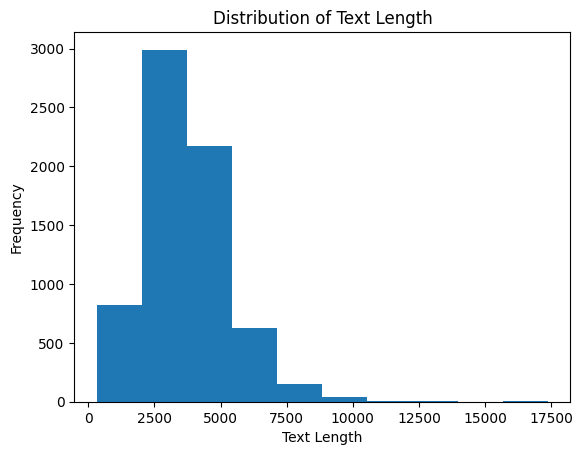

In [13]:

df['text_length'] = df['full_text'].apply(len)
plt.hist(df['text_length'], bins=10)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

#Checking the distribution of text length

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


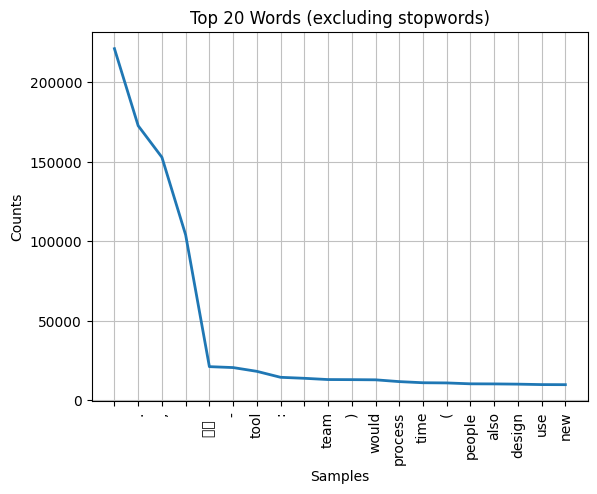

<Axes: title={'center': 'Top 20 Words (excluding stopwords)'}, xlabel='Samples', ylabel='Counts'>

In [14]:
import nltk
nltk.download('stopwords')  # Download stopwords dataset
from nltk.corpus import stopwords
###Checking the top 20 words across all documents not considering stop words
stop_words = set(stopwords.words('english'))
all_words = [word for tokens in df['tokens'] for word in tokens if word.lower() not in stop_words]
word_freq = nltk.FreqDist(all_words)
word_freq.plot(20, title="Top 20 Words (excluding stopwords)")

<h3> Tokens

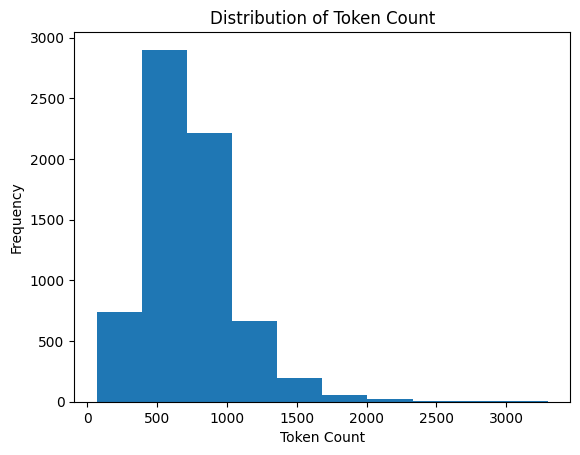

In [15]:


df['token_count'] = df['tokens'].apply(len)
plt.hist(df['token_count'], bins=10)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Count')
plt.show()

In [16]:
unique_tokens = set(all_words)
print(f"Number of unique tokens: {len(unique_tokens)}")

Number of unique tokens: 53642


In [17]:
### Identifying if tokens are already standardized

from collections import defaultdict


all_tokens = [token for sublist in df['tokens'] for token in sublist]

# Creating a dictionary to hold each unique token and its variations
token_variations = defaultdict(set)

# Populating the dictionary
for token in all_tokens:
    # Using a standardized form for matching
    standardized_token = token.lower()
    token_variations[standardized_token].add(token)

# Identifying tokens with variations
count=0
for standard_token, variations in token_variations.items():
    count+=1
    if len(variations) > 1 and count<50:
        print(f"Token: {standard_token}, Variations: {variations}")




####### The tokens are not completely inconsistency free

## We will check further to see if we have punctuational token variations

Token: design, Variations: {'Design', 'DESIGN', 'design'}
Token: thinking, Variations: {'thinking', 'Thinking', 'THINKING'}
Token: for, Variations: {'FOR', 'for', 'For'}
Token: innovation, Variations: {'INNOVATION', 'Innovation', 'innovation'}
Token: reflexion, Variations: {'reflexion', 'Reflexion'}
Token: challenge, Variations: {'challenge', 'Challenge', 'CHALLENGE'}
Token: selection, Variations: {'Selection', 'SELECTION', 'selection'}
Token: the, Variations: {'the', 'The', 'THE'}
Token: tool, Variations: {'TOOL', 'tool', 'Tool', 'TooL'}
Token: i, Variations: {'i', 'I'}
Token: use, Variations: {'use', 'USE', 'Use'}
Token: to, Variations: {'To', 'to', 'TO'}
Token: help, Variations: {'help', 'HELP', 'Help'}
Token: all, Variations: {'all', 'ALL', 'All'}
Token: stakeholders, Variations: {'stakeholders', 'STAKEHOLDERS', 'Stakeholders'}
Token: finding, Variations: {'finding', 'Finding'}
Token: their, Variations: {'THEIR', 'their', 'Their'}
Token: way, Variations: {'way', 'WAY', 'Way'}
Token

In [18]:
import string
from collections import defaultdict


all_tokens = [token for sublist in df['tokens'] for token in sublist]

# Function to remove punctuation from a token
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Dictionary to keep track of tokens with and without punctuation
tokens_with_without_punct = defaultdict(lambda: {'with': set(), 'without': set()})

for token in all_tokens:
    stripped_token = remove_punctuation(token)
    if stripped_token != token:
        # The token had punctuation and was modified
        tokens_with_without_punct[stripped_token]['with'].add(token)
    else:
        # The token had no punctuation to remove
        tokens_with_without_punct[stripped_token]['without'].add(token)

# Now, we'll find tokens that exist both with and without punctuation
tokens_with_both_forms = {token: forms for token, forms in tokens_with_without_punct.items() if forms['with'] and forms['without']}

# Display results


count=0

for token, forms in tokens_with_both_forms.items():
    print(f"Base Token: {token}, With Punctuation: {forms['with']}, Without Punctuation: {forms['without']}")
    count+=1
    if count==10:
        break


Base Token: Design, With Punctuation: {'Design--'}, Without Punctuation: {'Design'}
Base Token: Thinking, With Punctuation: {'Thinking-'}, Without Punctuation: {'Thinking'}
Base Token: for, With Punctuation: {'.for', '-for', 'for/'}, Without Punctuation: {'for'}
Base Token: innovation, With Punctuation: {'innovation-', '-innovation'}, Without Punctuation: {'innovation'}
Base Token: Challenge, With Punctuation: {'Challenge:-', 'Challenge-', '-Challenge-', 'Challenge/'}, Without Punctuation: {'Challenge'}
Base Token: selection, With Punctuation: {'selection-'}, Without Punctuation: {'selection'}
Base Token: The, With Punctuation: {'-The', '.The', 'The-'}, Without Punctuation: {'The'}
Base Token: tool, With Punctuation: {'-tool', 'tool-'}, Without Punctuation: {'tool'}
Base Token: I, With Punctuation: {'I.', '.I', '-I'}, Without Punctuation: {'I'}
Base Token: use, With Punctuation: {'use-', 'use/'}, Without Punctuation: {'use'}


### Based on the cell results above it seems like there exists token with punctuation versions

- Considering standardizing the tokens after a more basic EDA of the rest of the features

<h3> Label Distribution

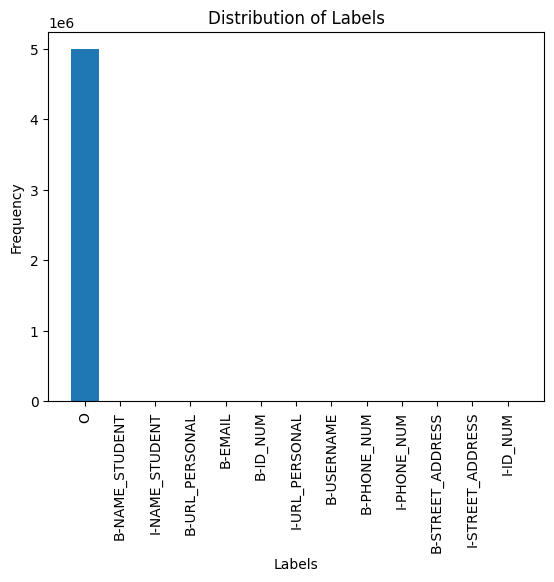

In [19]:
all_labels = [label for sublist in df['labels'] for label in sublist]
label_freq = nltk.FreqDist(all_labels)
plt.xticks(rotation=90)
plt.bar(label_freq.keys(), label_freq.values())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

In [20]:
!pip download Counter
from collections import  Counter
all_labels = [label for sublist in df['labels'] for label in sublist if label != "O"]

#  Count the frequencies of the worded labels
label_frequencies = Counter(all_labels)

#  Print the frequency of each label
for label, count in label_frequencies.items():
    print(f"{label}: {count}")

  File was already downloaded /content/Counter-1.0.0.tar.gz
  Preparing metadata (setup.py) ... done
Successfully downloaded Counter
B-NAME_STUDENT: 1365
I-NAME_STUDENT: 1096
B-URL_PERSONAL: 110
B-EMAIL: 39
B-ID_NUM: 78
I-URL_PERSONAL: 1
B-USERNAME: 6
B-PHONE_NUM: 6
I-PHONE_NUM: 15
B-STREET_ADDRESS: 2
I-STREET_ADDRESS: 20
I-ID_NUM: 1


In [21]:
### Checking out some rows with these labels present
labels_of_interest = ["B-EMAIL", "B-ID_NUM"]

for label in labels_of_interest:
    # Use a boolean mask to filter rows where our label of interest is found
    mask = df['labels'].apply(lambda x: label in x)

    # Display the filtered rows for this label
    display(df[mask].head())  # Using .head() to display a few rows, adjust as needed


,document,full_text,tokens,trailing_whitespace,labels,text_length,token_count
24,379,"COURSERA – University of Virginia, Darden Scho...","[COURSERA, –, University, of, Virginia, ,, Dar...","[True, True, True, True, False, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",4244,766
86,2769,Design Thinking for Innovation\n\nby Universit...,"[Design, Thinking, for, Innovation, \n\n, by, ...","[True, True, True, False, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",3084,623
134,3709,", Vol.7, No.5, May 2009\n\nE-ISSN: 2321-9637\n...","[,, Vol.7, ,, No.5, ,, May, 2009, \n\n, E, -, ...","[True, False, True, False, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",12098,2456
171,4227,Mohamed Smith (agood@gmail.com)\n\nVisualizati...,"[Mohamed, Smith, (, agood@gmail.com, ), \n\n, ...","[True, True, False, False, False, False, False...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-EMAIL, O...",4118,803
185,4381,"WRITING CENTRE Level 3 East, Hub Central Nor...","[WRITING, CENTRE, , Level, 3, East, ,, Hub, C...","[True, True, False, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",6147,1222


,document,full_text,tokens,trailing_whitespace,labels,text_length,token_count
29,609,Date:14-09-2021\n\nNEWS PAPER\n\nProject: News...,"[Date:14, -, 09, -, 2021, \n\n, NEWS, PAPER, \...","[False, False, False, False, False, False, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",4195,915
99,2926,NAME: Ignacia Hernandez Roll No. : 932353568...,"[NAME, :, Ignacia, Hernandez, , Roll, No, .,...","[False, True, True, True, False, True, False, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O...",1774,429
124,3565,Project: Experiment sheet (5W+H)\n\nInterview...,"[Project, :, , Experiment, sheet, (, 5W+H, ),...","[False, True, False, True, True, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...",1756,428
213,4717,STORY TELLING\n\nPIN NO. :163133980712 NAME ...,"[STORY, TELLING, \n\n, PIN, NO, ., :, 16313398...","[True, False, False, True, False, True, False,...","[O, O, O, O, O, O, O, B-ID_NUM, O, O, O, B-NAM...",1946,443
231,4913,DESIGN THINKING\n\nEXPERIMENT – 2\n\nName: Niz...,"[DESIGN, THINKING, \n\n, EXPERIMENT, –, 2, \n\...","[True, False, False, True, True, False, False,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",2471,605


<h4> Wordcloud for Text

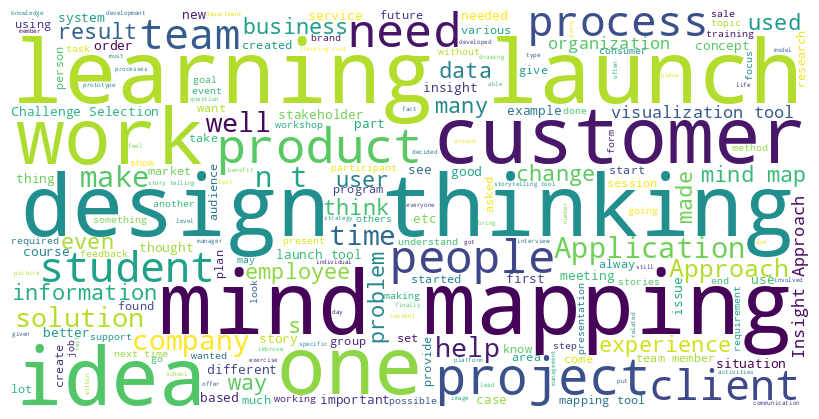

In [22]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(all_words))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### First Attempt : For the first attempt, we will not be adding addtional datasets. We'll try and optimize the exisiting features through EDA and applicable transformations before deciding on the model

### This alligns with a Named Entity Recognition (NER) task

#### For label observations we know that the ratio of '0' in the label lists are way higher than the worded labels. We'll print out some of the document rows with the worded labels, which will help get an overview of what PII exists in the text of a document row

In [23]:
def print_labels_with_values(df):
    for index, row in df.iterrows():
        print(f"Document number {row['document']}:")

        # Zip together the tokens and labels for parallel iteration
        paired = list(zip(row['tokens'], row['labels']))

        # Filter out pairs where label is 'O', and print remaining tokens with their labels
        for token, label in paired:
            if label != 'O':
                print(f"\tToken: {token}, Label: {label}")
        print("-" * 50)  # Separator for readability

print_labels_with_values(df[300:350])

Document number 5716:
	Token: meyermichelle, Label: B-USERNAME
--------------------------------------------------
Document number 5717:
	Token: Natalya, Label: B-NAME_STUDENT
	Token: Kotov, Label: I-NAME_STUDENT
--------------------------------------------------
Document number 5731:
	Token: Abdul, Label: B-NAME_STUDENT
	Token: Rohim, Label: I-NAME_STUDENT
	Token: Abdul, Label: B-NAME_STUDENT
	Token: Rohim, Label: I-NAME_STUDENT
--------------------------------------------------
Document number 5736:
	Token: Pietro, Label: B-NAME_STUDENT
	Token: Gabrielli, Label: I-NAME_STUDENT
--------------------------------------------------
Document number 5738:
	Token: Kara, Label: B-NAME_STUDENT
	Token: Deniz, Label: I-NAME_STUDENT
--------------------------------------------------
Document number 5748:
	Token: Mohamed, Label: B-NAME_STUDENT
	Token: Kamal, Label: I-NAME_STUDENT
	Token: Mohamed, Label: B-NAME_STUDENT
	Token: Kamal, Label: I-NAME_STUDENT
--------------------------------------------

# Modelling on un-formatted Datatset (No featurization) to test out baseline performance

**Checking to see if allignment is needed**

In [24]:
from transformers import AutoTokenizer

# Initializing the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Example text and tokens from your dataset
original_tokens = df['tokens'][0]
original_text = df['full_text'][0]

# Tokenize the text
tokenized_output = tokenizer(original_text, is_split_into_words=False)

# Tokenize using the tokens directly (assuming the dataset tokens are whitespace-separated)
tokenized_output_from_tokens = tokenizer(original_tokens, is_split_into_words=True)

# Compare
print("Original Tokens:", original_tokens)
print("Tokens from Text:", tokenizer.convert_ids_to_tokens(tokenized_output['input_ids']))
print("Tokens from Original Tokens:", tokenizer.convert_ids_to_tokens(tokenized_output_from_tokens['input_ids']))

# Check if alignment is needed
if len(original_tokens) != len(tokenized_output_from_tokens['input_ids']) - 2:  # Subtract 2 for special tokens ([CLS], [SEP])
    print("Alignment is needed.")
else:
    print("No alignment needed.")


Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


Original Tokens: ['Design', 'Thinking', 'for', 'innovation', 'reflexion', '-', 'Avril', '2021', '-', 'Nathalie', 'Sylla', '\n\n', 'Challenge', '&', 'selection', '\n\n', 'The', 'tool', 'I', 'use', 'to', 'help', 'all', 'stakeholders', 'finding', 'their', 'way', 'through', 'the', 'complexity', 'of', 'a', 'project', 'is', 'the', ' ', 'mind', 'map', '.', '\n\n', 'What', 'exactly', 'is', 'a', 'mind', 'map', '?', 'According', 'to', 'the', 'definition', 'of', 'Buzan', 'T.', 'and', 'Buzan', 'B.', '(', '1999', ',', 'Dessine', '-', 'moi', ' ', "l'intelligence", '.', 'Paris', ':', 'Les', 'Éditions', "d'Organisation", '.', ')', ',', 'the', 'mind', 'map', '(', 'or', 'heuristic', 'diagram', ')', 'is', 'a', 'graphic', ' ', 'representation', 'technique', 'that', 'follows', 'the', 'natural', 'functioning', 'of', 'the', 'mind', 'and', 'allows', 'the', 'brain', "'s", ' ', 'potential', 'to', 'be', 'released', '.', 'Cf', 'Annex1', '\n\n', 'This', 'tool', 'has', 'many', 'advantages', ':', '\n\n', '•', ' ', '

In [25]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

In [26]:
dataset = Dataset.from_pandas(pd.DataFrame(df))

In [27]:
# Get the unique labels from the dataset
unique_labels = set(label for doc_labels in dataset['labels'] for label in doc_labels)
# Create the label to id mapping
label_to_id = {label: id for id, label in enumerate(unique_labels)}

In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Define a function that will tokenize the text and map the labels onto the tokenized text
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Apply the tokenization and label alignment function to your dataset
tokenized_and_aligned_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [29]:
from datasets import DatasetDict

# Split the dataset into a training and validation set
train_test_split = tokenized_and_aligned_datasets.train_test_split(test_size=0.1)
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

In [30]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


In [32]:
from sklearn.metrics import fbeta_score, precision_score, recall_score

def compute_metrics(p):
    # Convert logits to predictions
    preds = np.argmax(p.predictions, axis=2).flatten()

    # Flatten the labels
    actuals = p.label_ids.flatten()

    # Filter out the special tokens
    non_ignore_indices = actuals != -100
    actuals = actuals[non_ignore_indices]
    preds = preds[non_ignore_indices]

    # Calculate scores
    f_beta = fbeta_score(actuals, preds, beta=5, average='micro')
    precision = precision_score(actuals, preds, average='micro')
    recall = recall_score(actuals, preds, average='micro')

    return {
        'f_beta': f_beta,
        'precision': precision,
        'recall': recall
    }


In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
10,2.633600
20,2.462600
30,2.080200
40,1.306700
50,0.461100
60,0.100000
70,0.024500
80,0.013000
90,0.009700
100,0.008900


TrainOutput(global_step=2298, training_loss=0.040898973470801174, metrics={'train_runtime': 1971.8019, 'train_samples_per_second': 9.32, 'train_steps_per_second': 1.165, 'total_flos': 4802589366884352.0, 'train_loss': 0.040898973470801174, 'epoch': 3.0})

<h1> Evaluation <h1>

- Checking out the f-beta score on the base bert-uncased-model

In [37]:
evaluation_result = trainer.evaluate()
print(evaluation_result)


{'eval_loss': 0.0004636876401491463, 'eval_f_beta': 0.9998717015264311, 'eval_precision': 0.9998717015264311, 'eval_recall': 0.9998717015264311, 'eval_runtime': 21.9275, 'eval_samples_per_second': 31.057, 'eval_steps_per_second': 3.922, 'epoch': 3.0}


<h1> Checking on Test Data

In [38]:
df_test = pd.read_json('gdrive/My Drive/pii-detection/test.json')

In [39]:
df_test

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr..."


In [40]:
test_dataset = Dataset.from_pandas(df_test)

In [41]:
def tokenize_for_prediction(examples):
    # Tokenize the inputs (text) for prediction
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, padding="max_length", max_length=512, is_split_into_words=True)
    return tokenized_inputs

# Apply the tokenize function to the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_for_prediction, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [43]:
# Generate predictions
predictions = trainer.predict(tokenized_test_dataset)
predictions = np.argmax(predictions.predictions, axis=2)

In [46]:
id_to_label = {id: label for label, id in label_to_id.items()}
prediction_labels = [[id_to_label[pred] for pred in prediction_row if pred != -100] for prediction_row in predictions]


In [47]:
# Initialize a list to hold submission data
submission_data = []

# Correctly accessing each document's predictions
for i, (example, prediction) in enumerate(zip(tokenized_test_dataset, predictions)):
    tokens = example['tokens']

    # Ensure prediction is properly accessed; no need for prediction_indices[0]
    # Directly iterate over prediction if it's already a sequence of indices for the document
    for token_index, pred_index in enumerate(prediction):  # Adjusted line
        label = id_to_label.get(pred_index, "O")  # Default to "O" if not found
        if label != "O":
            # Create a row for each positive PII label prediction
            submission_data.append({
                "row_id": f"{i}_{token_index}",
                "document_id": i,  # Assuming you want to track document ID
                "token_index": token_index,
                "label": label
            })

# Convert submission data to a DataFrame
submission_df = pd.DataFrame(submission_data)


In [48]:
submission_df.head()

,row_id,document_id,token_index,label
0,0_12,0,12,B-NAME_STUDENT
1,0_13,0,13,B-NAME_STUDENT
2,0_14,0,14,B-NAME_STUDENT
3,0_15,0,15,I-NAME_STUDENT
4,0_16,0,16,I-NAME_STUDENT


In [49]:
submission_df.to_csv("submission.csv", index=False)